# 3.3 GDAL, and OGR masking

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#3.3-GDAL,-and-OGR-masking" data-toc-modified-id="3.3-GDAL,-and-OGR-masking-3.1">3.3 GDAL, and OGR masking</a></span><ul class="toc-item"><li><span><a href="#3.3.1-The-MODIS-LAI-data" data-toc-modified-id="3.3.1-The-MODIS-LAI-data-3.1.1">3.3.1 The MODIS LAI data</a></span><ul class="toc-item"><li><span><a href="#3.3.1.1-try-...-except-..." data-toc-modified-id="3.3.1.1-try-...-except-...-3.1.1.1">3.3.1.1 <code>try ... except ...</code></a></span></li><li><span><a href="#3.3.1.2-Get-data" data-toc-modified-id="3.3.1.2-Get-data-3.1.1.2">3.3.1.2 Get data</a></span></li><li><span><a href="#3.3.1.3-File-Naming-Convention" data-toc-modified-id="3.3.1.3-File-Naming-Convention-3.1.1.3">3.3.1.3 File Naming Convention</a></span></li><li><span><a href="#3.3.1.2-Dataset-Naming-Convention" data-toc-modified-id="3.3.1.2-Dataset-Naming-Convention-3.1.1.4">3.3.1.2 Dataset Naming Convention</a></span></li></ul></li><li><span><a href="#3.3.2-MODIS-dataset-access" data-toc-modified-id="3.3.2-MODIS-dataset-access-3.1.2">3.3.2 MODIS dataset access</a></span><ul class="toc-item"><li><span><a href="#3.3.2.1-gdal.ReadAsArray()" data-toc-modified-id="3.3.2.1-gdal.ReadAsArray()-3.1.2.1">3.3.2.1 <code>gdal.ReadAsArray()</code></a></span></li><li><span><a href="#3.3.2.2-Metadata" data-toc-modified-id="3.3.2.2-Metadata-3.1.2.2">3.3.2.2 Metadata</a></span></li></ul></li><li><span><a href="#3.3.3-Reading-and-displaying-data" data-toc-modified-id="3.3.3-Reading-and-displaying-data-3.1.3">3.3.3 Reading and displaying data</a></span><ul class="toc-item"><li><span><a href="#3.3.3.1-glob" data-toc-modified-id="3.3.3.1-glob-3.1.3.1">3.3.3.1 <code>glob</code></a></span></li><li><span><a href="#3.3.3.2-reading-and-displaying-image-data" data-toc-modified-id="3.3.3.2-reading-and-displaying-image-data-3.1.3.2">3.3.3.2 reading and displaying image data</a></span></li><li><span><a href="#3.3.3.3-subplot-plotting" data-toc-modified-id="3.3.3.3-subplot-plotting-3.1.3.3">3.3.3.3 subplot plotting</a></span></li><li><span><a href="#3.3.3.3-tile-stitching" data-toc-modified-id="3.3.3.3-tile-stitching-3.1.3.4">3.3.3.3 tile stitching</a></span></li><li><span><a href="#3.3.3.4-gdal-virtual-file" data-toc-modified-id="3.3.3.4-gdal-virtual-file-3.1.3.5">3.3.3.4 <code>gdal</code> virtual file</a></span></li></ul></li><li><span><a href="#3.3.4-The-country-borders-dataset" data-toc-modified-id="3.3.4-The-country-borders-dataset-3.1.4">3.3.4 The country borders dataset</a></span></li></ul></li></ul></div>

[[up to 3.0](Chapter3_1_GDAL.ipynb)]


In this section, we'll look at combining both raster and vector data to provide a masked dataset ready to use. We will produce a combined dataset of leaf area index (LAI) over the UK derived from the MODIS sensor. The MODIS LAI product is produced every 4 days and it is provided spatially tiled. Each tile covers around 1200 km x 1200 km of the Earth's surface. Below you can see a map showing the MODIS tiling convention.



## 3.3.1 The MODIS LAI data

Let's first test your NASA login:


In [1]:
import geog0111.nasa_requests as nasa_requests
from geog0111.cylog import cylog
%matplotlib inline

url = 'https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2018.09.30/' 
        
# grab the HTML information
try:
    html = nasa_requests.get(url).text
    # test a few lines of the html
    if html[:20] == '<!DOCTYPE HTML PUBLI':
        print('this seems to be ok ... ')
        print('use cylog().login() anywhere you need to specify the tuple (username,password)')
except:
    print('login error ... try entering your username password again')
    print('then re-run this cell until it works')
    cylog(init=True)

this seems to be ok ... 
use cylog().login() anywhere you need to specify the tuple (username,password)


### 3.3.1.1 `try ... except ...` 

Note that we have used a `try ... except` structure above to trap any errors.

In [57]:
import sys
try:
    # variable stupid not set
    print("I'm trying this but it will fail",stupid)
except NameError:
    '''
    trap the error
    (and ideally define some sensible behaviour)
    '''
    print("unset variable:",sys.exc_info()[1])
except:
    print("In case of other errors")
    print(sys.exc_info())
    # raise our own exception
    raise Exception('bad code')

unset variable: name 'stupid' is not defined


Generally, you should try to foresee the types of error you might generate, and provide specific traps for these so youy can control the code better.

In the case above, we allow the code execution to continue with a `NameError`, but raise a further exception in case of any other errors.

`sys.exc_info()` provides a tuple of information on what happened.

**Exercise**

* Write some code using `try ... except` to trap a `ZeroDivisionError` 
* provide a sensible result in such a case

**hint**

If you divide by zero, the result will be infinity, which is often not what you want to happen. Instead, try dividing by a small number, such as that provided by `sys.float_info.epsilon`.

In [ ]:
# do exercise here

### 3.3.1.2 Get data

You should by now be able to download MODIS data, but in this case, the data are provided (or downloaded for you) in the `data` folder as files `MCD15A3H.A2018273.h17v03.006.2018278143630.hdf`  and `MCD15A3H.A2018273.h18v03.006.2018278143633.hdf` (and some files `*v04*hdf` we will need later) by running the code below.

In [3]:
from geog0111.geog_data import *

filenames = ['MCD15A3H.A2018273.h17v03.006.2018278143630.hdf', \
            'MCD15A3H.A2018273.h18v03.006.2018278143633.hdf',\
            'MCD15A3H.A2018273.h17v04.006.2018278143630.hdf',\
            'MCD15A3H.A2018273.h18v04.006.2018278143638.hdf']
destination_folder="data"

for file_name in filenames:
    f = procure_dataset(file_name,verbose=True,\
                        destination_folder=destination_folder)
    print(file_name,f)

MCD15A3H.A2018273.h17v03.006.2018278143630.hdf True
MCD15A3H.A2018273.h18v03.006.2018278143633.hdf True
MCD15A3H.A2018273.h17v04.006.2018278143630.hdf True
MCD15A3H.A2018273.h18v04.006.2018278143638.hdf True


We want to select the LAI layers, so let's have a look at the contents ('sub datasets') of one of the files.

To do this with `gdal`:

* make the full filename (folder name, plus the filename in that folder). Use `Path` for this, but convert to a string.
* open the file, store as `g`
* get the list `g.GetSubDatasets()` and loop over this

In [4]:
import gdal
from pathlib import Path
from geog0111.geog_data import *

filenames = ['MCD15A3H.A2018273.h17v03.006.2018278143630.hdf', \
            'MCD15A3H.A2018273.h18v03.006.2018278143633.hdf']
destination_folder="data"

for file_name in filenames:
    # form full filename as a string
    # and print with an underline of = 
    file_name = Path(destination_folder).joinpath(file_name).as_posix()
    print(file_name)
    print('='*len(file_name))
    
    # open the file as g
    g = gdal.Open(file_name)
    # loop over the subdatasets
    for d in g.GetSubDatasets():
        print(d)

data/MCD15A3H.A2018273.h17v03.006.2018278143630.hdf
('HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018273.h17v03.006.2018278143630.hdf":MOD_Grid_MCD15A3H:Fpar_500m', '[2400x2400] Fpar_500m MOD_Grid_MCD15A3H (8-bit unsigned integer)')
('HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018273.h17v03.006.2018278143630.hdf":MOD_Grid_MCD15A3H:Lai_500m', '[2400x2400] Lai_500m MOD_Grid_MCD15A3H (8-bit unsigned integer)')
('HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018273.h17v03.006.2018278143630.hdf":MOD_Grid_MCD15A3H:FparLai_QC', '[2400x2400] FparLai_QC MOD_Grid_MCD15A3H (8-bit unsigned integer)')
('HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018273.h17v03.006.2018278143630.hdf":MOD_Grid_MCD15A3H:FparExtra_QC', '[2400x2400] FparExtra_QC MOD_Grid_MCD15A3H (8-bit unsigned integer)')
('HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018273.h17v03.006.2018278143630.hdf":MOD_Grid_MCD15A3H:FparStdDev_500m', '[2400x2400] FparStdDev_500m MOD_Grid_MCD15A3H (8-bit unsigned integer)')
('HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018273.h17v03.006.2018278143630.h

So we see that the data is in `HDF4` format, and that it has a number of layers. The dataset/layer we're interested in

`HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018273.h18v03.006.2018278143633.hdf":MOD_Grid_MCD15A3H:Lai_500m`.


### 3.3.1.3 File Naming Convention

This section taken from [NASA MODIS product page](https://nsidc.org/data/mod10a1).

Example File Name:

`data/MOD10A1.A2000055.h15v01.006.2016061160800.hdf`



`FOLDER/MOD[PID].A[YYYY][DDD].h[NN]v[NN].[VVV].[yyyy][ddd][hhmmss].hdf`

Refer to Table 3.3.1 for descriptions of the file name variables listed above.



|  Variable | Description  |  
|---|---|
| FOLDER| folder/directory name of file|
| MOD  |  MODIS/Terra  (`MCD` means combined)| 
|  PID |   Product ID|  
| A	|Acquisition date follows|
|YYYY	|Acquisition year|
|DDD	|Acquisition day of year|
|h[NN]v[NN]	|Horizontal tile number and vertical tile number (see Grid for details.)|
|VVV	|Version (Collection) number|
|yyyy	|Production year|
|ddd	|Production day of year|
|hhmmss	|Production hour/minute/second in GMT|
|.hdf	|HDF-EOS formatted data file|
Table 3.3.1. Variables in the MODIS File Naming Convention

![](https://nsidc.org/sites/nsidc.org/files/images/modis-sin-grid.png)


### 3.3.1.2 Dataset Naming Convention

Example Dataset Name:

`HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018273.h18v03.006.2018278143633.hdf":MOD_Grid_MCD15A3H:Lai_500m`


`FORMAT:"FILENAME":MOD_Grid_PRODUCT:LAYER`

|  Variable | Description  |  
|---|---|
|FORMAT| file format, `HDF4_EOS:EOS_GRID`|
|FILENAME| dataset file name, see below|
|PRODUCT| MODIS product code e.g. `MCD15A3H`|
|LAYER| sub-dataset name e.g. `Lai_500m`|
Table 3.3.2. Variables in the MODIS Dataset Naming Convention


**Exercise E3.3.1**

* Check you're happy that the other datasets (e.g. `LaiStdDev_500m`) follow the same convention as `Lai_500m`
* work out what the dataset/layer name would be for the dataset product `MOD10A1` version `6` for the $1^{st}$ January 2018, for tile `h25v06` for the layer `NDSI_Snow_Cover`. You will find product information [on the relevant NASA page](https://nsidc.org/data/mod10a1). You may not be able to access the production date/time, but just put a placeholder for that now.
* phrase the filename and layer name as '`f`' strings, e.g. starting `f'HDF4_EOS:EOS_GRID:"{filename}":MOD_Grid_{}'` etc.

**Hint**:

You can explore the filenames by looking into the [Earthdata link](https://n5eil01u.ecs.nsidc.org/MOSA/).

![](images/BROWSE.MYD10A1.A2018001.h25v05.006.2018003025825.1.jpg)

In [5]:
# do exercise here

## 3.3.2 MODIS dataset access

### 3.3.2.1 `gdal.ReadAsArray()`

We can now access the dataset names and open the datasets in `gdal` directly, e.g.:

`HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018273.h18v03.006.2018278143633.hdf":MOD_Grid_MCD15A3H:Lai_500m`

We can read the dataset with `g.ReadAsArray()`, after we have opened it. It returns a numpy array.

In [6]:
import gdal
import numpy as np

filename = 'data/MCD15A3H.A2018273.h17v03.006.2018278143630.hdf'
dataset_name = f'HDF4_EOS:EOS_GRID:"{filename:s}":MOD_Grid_MCD15A3H:Lai_500m'
print(f"dataset: {dataset_name}")

g = gdal.Open(dataset_name)
data = g.ReadAsArray()

print(type(data))
print('max:',data.max())
print('max:',data.min())
# get unique values, for interst
print('unique values:',np.unique(data))

dataset: HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018273.h17v03.006.2018278143630.hdf":MOD_Grid_MCD15A3H:Lai_500m
<class 'numpy.ndarray'>
max: 255
max: 0
unique values: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70 250
 253 254 255]


**Exercise E3.3.2**

* print out some further summary statistics of the dataset
* print out the data type and `shape`
* how many rows and columns does the dataset have?

In [7]:
# do exercise here

### 3.3.2.2 Metadata

There will generally be a set of metadata associated with a geospatial dataset. This will describe e.g. the processing chain, special codes in the dataset, and projection and other information.

In `gdal`, w access the metedata using `g.GetMetadata()`. A dictionary is returned.

In [8]:
filename = 'data/MCD15A3H.A2018273.h17v03.006.2018278143630.hdf'
dataset_name = f'HDF4_EOS:EOS_GRID:"{filename:s}":MOD_Grid_MCD15A3H:Lai_500m'
g = gdal.Open(dataset_name)

print ("\nMetedata Keys:\n")
# get the metadata dictionary keys
for k in g.GetMetadata().keys():
    print(k)


Metedata Keys:

add_offset
add_offset_err
ALGORITHMPACKAGEACCEPTANCEDATE
ALGORITHMPACKAGEMATURITYCODE
ALGORITHMPACKAGENAME
ALGORITHMPACKAGEVERSION
ASSOCIATEDINSTRUMENTSHORTNAME.1
ASSOCIATEDINSTRUMENTSHORTNAME.2
ASSOCIATEDPLATFORMSHORTNAME.1
ASSOCIATEDPLATFORMSHORTNAME.2
ASSOCIATEDSENSORSHORTNAME.1
ASSOCIATEDSENSORSHORTNAME.2
AUTOMATICQUALITYFLAG.1
AUTOMATICQUALITYFLAGEXPLANATION.1
calibrated_nt
CHARACTERISTICBINANGULARSIZE500M
CHARACTERISTICBINSIZE500M
DATACOLUMNS500M
DATAROWS500M
DAYNIGHTFLAG
DESCRREVISION
EASTBOUNDINGCOORDINATE
ENGINEERING_DATA
EXCLUSIONGRINGFLAG.1
GEOANYABNORMAL
GEOESTMAXRMSERROR
GLOBALGRIDCOLUMNS500M
GLOBALGRIDROWS500M
GRANULEBEGINNINGDATETIME
GRANULEDAYNIGHTFLAG
GRANULEENDINGDATETIME
GRINGPOINTLATITUDE.1
GRINGPOINTLONGITUDE.1
GRINGPOINTSEQUENCENO.1
HDFEOSVersion
HORIZONTALTILENUMBER
identifier_product_doi
identifier_product_doi_authority
INPUTPOINTER
LOCALGRANULEID
LOCALVERSIONID
LONGNAME
long_name
MAXIMUMOBSERVATIONS500M
MOD15A1_ANC_BUILD_CERT
MOD15A2_FILLVALUE_

Let's look at some of these metadata fields:

In [9]:
import gdal
import numpy as np

filename = 'data/MCD15A3H.A2018273.h17v03.006.2018278143630.hdf'
dataset_name = f'HDF4_EOS:EOS_GRID:"{filename:s}":MOD_Grid_MCD15A3H:Lai_500m'
print(f"dataset: {dataset_name}")

g = gdal.Open(dataset_name)
# get the metadata dictionary keys
for k in ["LONGNAME","CHARACTERISTICBINSIZE500M",\
          "MOD15A2_FILLVALUE_DOC",\
          "GRINGPOINTLATITUDE.1","GRINGPOINTLONGITUDE.1",\
          'scale_factor']:
    print(k,g.GetMetadata()[k])

dataset: HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018273.h17v03.006.2018278143630.hdf":MOD_Grid_MCD15A3H:Lai_500m
LONGNAME MODIS/Terra+Aqua Leaf Area Index/FPAR 4-Day L4 Global 500m SIN Grid
CHARACTERISTICBINSIZE500M 463.312716527778
MOD15A2_FILLVALUE_DOC MOD15A2 FILL VALUE LEGEND
255 = _Fillvalue, assigned when:
    * the MOD09GA suf. reflectance for channel VIS, NIR was assigned its _Fillvalue, or
    * land cover pixel itself was assigned _Fillvalus 255 or 254.
254 = land cover assigned as perennial salt or inland fresh water.
253 = land cover assigned as barren, sparse vegetation (rock, tundra, desert.)
252 = land cover assigned as perennial snow, ice.
251 = land cover assigned as "permanent" wetlands/inundated marshlands.
250 = land cover assigned as urban/built-up.
249 = land cover assigned as "unclassified" or not able to determine.

GRINGPOINTLATITUDE.1 49.7394264948349, 59.9999999946118, 60.0089388384779, 49.7424953501575
GRINGPOINTLONGITUDE.1 -15.4860189105775, -19.9999999949462, 0

So we see that the datasets use the MODIS Sinusoidal projection. Also we see that the pixel spacing is around 463m, there is a scale factor of 0.1 to be applied etc.

**Exercise E3.3.3**

look at the metadata to discover:

* the number of rows and columns in the dataset
* the range of valid values

In [10]:
# do exercise here

## 3.3.3 Reading and displaying data

### 3.3.3.1 `glob`

Let us now suppose that we want to examine an `hdf` file that we have previously downloaded and stored in the directiory `data`.

How can we get a view into this directory to the the names of the files there?

The answer to this is `glob`, which we can access from the `pathlib` module.

Let's look in the `data` directory:

In [11]:
from pathlib import Path

# look in this directory
in_directory = Path('data')

filenames = in_directory.glob('*')
print('files in the directory',in_directory,':')
for f in filenames:
    print(f.name)

files in the directory data :
MCD15A3H.A2016005.h17v04.006.2016013011406.hdf
MCD15A3H.A2016001.h18v04.006.2016007073726.hdf
MCD15A3H.A2016021.h18v03.006.2016026124743.hdf
MCD15A3H.A2018273.h17v04.006.2018278143630.hdf
MCD15A3H.A2016021.h17v03.006.2016026124738.hdf
MCD15A3H.A2016013.h17v03.006.2016020015242.hdf
airtravel.csv
MCD15A3H.A2016033.h17v04.006.2016043140634.hdf
MCD15A3H.A2016009.h18v03.006.2016014073048.hdf
test_image.bin
MCD15A3H.A2016033.h18v03.006.2016043140641.hdf
MCD15A3H.A2018273.h18v03.006.2018278143633.hdf
MCD15A3H.A2016021.h18v04.006.2016026124707.hdf
MCD15A3H.A2016005.h17v03.006.2016013012017.hdf
satellites-1957-2019.gz
MCD15A3H.A2016017.h17v04.006.2016027192758.hdf
TM_WORLD_BORDERS-0.3.prj
MCD15A3H.A2016029.h17v03.006.2016043140323.hdf
saved_daymet.csv
TM_WORLD_BORDERS-0.3.zip
MCD15A3H.A2016013.h17v04.006.2016020020246.hdf
MCD15A3H.A2016009.h18v04.006.2016014074158.hdf
MCD15A3H.A2016017.h17v03.006.2016027192752.hdf
MCD15A3H.A2018273.h18v04.006.2018278143638.hdf
MCD1

We use the argument `'data/*'` where `*` is a wildcard. Any filenames that match this pattern will be returned as a list.

If we want the list sorted, we need to use the `sorted()` method. This is similar to the list `sort` we have seen previously, but returns the sorted list.

The wildcard `*` here means a match to zero or more characters, so this is matching all names in the directory `data`. The wildcard `**` would mean [all files here and all sub-directories](https://docs.python.org/3/library/pathlib.html#pathlib.Path.glob).



We could be more subtle with this, e.g. matching only files ending `hdf`:

In [12]:
from pathlib import Path

filenames = sorted(Path('data').glob('*'))

for f in filenames:
    print(f.name)

MCD15A3H.A2016001.h17v03.006.2016007075833.hdf
MCD15A3H.A2016001.h17v04.006.2016007074809.hdf
MCD15A3H.A2016001.h18v03.006.2016007073724.hdf
MCD15A3H.A2016001.h18v04.006.2016007073726.hdf
MCD15A3H.A2016005.h17v03.006.2016013012017.hdf
MCD15A3H.A2016005.h17v04.006.2016013011406.hdf
MCD15A3H.A2016005.h18v03.006.2016013012348.hdf
MCD15A3H.A2016005.h18v04.006.2016013012025.hdf
MCD15A3H.A2016009.h17v03.006.2016014071957.hdf
MCD15A3H.A2016009.h17v04.006.2016014072006.hdf
MCD15A3H.A2016009.h18v03.006.2016014073048.hdf
MCD15A3H.A2016009.h18v04.006.2016014074158.hdf
MCD15A3H.A2016013.h17v03.006.2016020015242.hdf
MCD15A3H.A2016013.h17v04.006.2016020020246.hdf
MCD15A3H.A2016013.h18v03.006.2016020014424.hdf
MCD15A3H.A2016013.h18v04.006.2016020014435.hdf
MCD15A3H.A2016017.h17v03.006.2016027192752.hdf
MCD15A3H.A2016017.h17v04.006.2016027192758.hdf
MCD15A3H.A2016017.h18v03.006.2016027193558.hdf
MCD15A3H.A2016017.h18v04.006.2016027193356.hdf
MCD15A3H.A2016021.h17v03.006.2016026124738.hdf
MCD15A3H.A201

**Exercise 3.3.4**

* adapt the code above to return only hdf filenames for the tile `h18v03`

In [13]:
# do exercise here

### 3.3.3.2 reading and displaying image data

Let's now read some data as above.

we do this with:

    g.Open(gdal_fname)
    data = g.ReadAsArray()
    
Originally the data are `uint8` (unsigned 8 bit data), but we need to multiply them by `scale_factor` (0.1 here) to convert to physical units. This also casts the data type to `float`.

We can straightforwardly plot the images using `matplotlib`. We first importt the library:

    import matplotlib.pylab as plt
    
Then set up the figure size:

    plt.figure(figsize=(10,10))
    
Plot the image:

    plt.imshow( data, vmin=0, vmax=6,cmap=plt.cm.inferno_r)
    
where here `data` is a 2-D dataset. We can set limits to the image scaling (`vmin`, `vmax`), so that we emphasise a particular range of values, and we can apply custom colourmaps (`cmap=plt.cm.inferno_r`).

Finally here, we set a title, and plot a colour wedge to show the data scale. The `scale=0.8` here allows us to align the size of the scale with the plotted image size.

    plt.title(dataset_name)
    plt.colorbar(shrink=0.8)
    
If we want to save the plotted image to a file, e.g. in the directory `images`, we use:

    plt.savefig(out_filename)
    
    

HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018273.h17v03.006.2018278143630.hdf":MOD_Grid_MCD15A3H:Lai_500m 0.1
**************************************************************************************************
<class 'numpy.ndarray'> uint8 (2400, 2400) 

<class 'numpy.ndarray'> float64 (2400, 2400) 

MCD15A3H.A2018273.h17v03.006.2018278143630.png
HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018273.h18v03.006.2018278143633.hdf":MOD_Grid_MCD15A3H:Lai_500m 0.1
**************************************************************************************************
<class 'numpy.ndarray'> uint8 (2400, 2400) 

<class 'numpy.ndarray'> float64 (2400, 2400) 

MCD15A3H.A2018273.h18v03.006.2018278143633.png


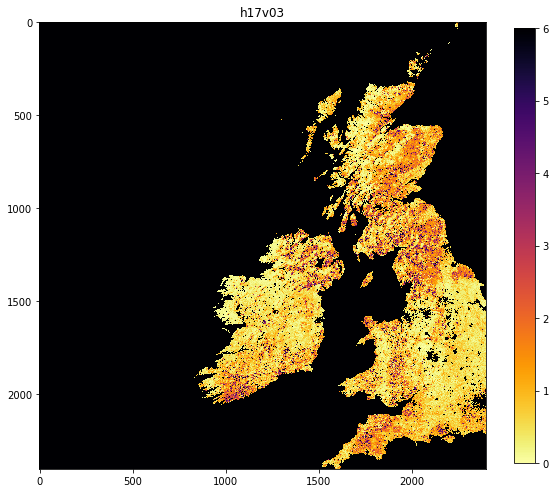

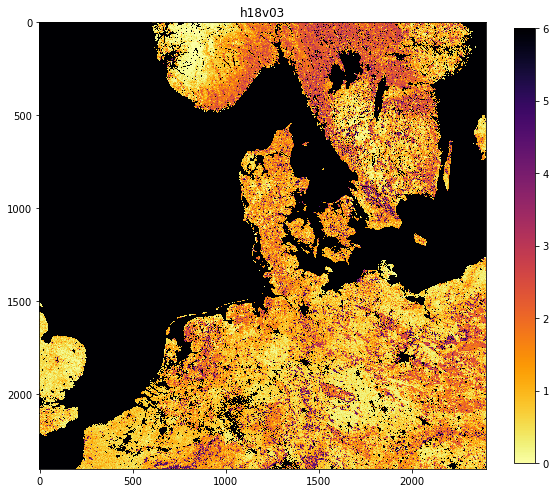

In [14]:
import gdal
from pathlib import Path
import matplotlib.pylab as plt

# get only v03 hdf names
filenames = sorted(Path('data').glob('*2018*v03*.hdf'))


out_directory = Path('images')

for filename in filenames:
    # pull the tile name from the filename
    # to use as plot title
    tile = filename.name.split('.')[2]
    
    dataset_name = f'HDF4_EOS:EOS_GRID:"{str(filename):s}\":MOD_Grid_MCD15A3H:Lai_500m'
    g = gdal.Open(dataset_name)
    data = g.ReadAsArray()
    scale_factor = float(g.GetMetadata()['scale_factor'])
    
    print(dataset_name,scale_factor)
    print('*'*len(dataset_name))
    print(type(data),data.dtype,data.shape,'\n')
    
    data = data * scale_factor
    print(type(data),data.dtype,data.shape,'\n')
    plt.figure(figsize=(10,10))
    plt.imshow( data, vmin=0, vmax=6,cmap=plt.cm.inferno_r)
    plt.title(tile)
    plt.colorbar(shrink=0.8)
    
    # save figure as png
    plot_name = filename.stem + '.png'
    print(plot_name)
    out_filename = out_directory.joinpath(plot_name)
    plt.savefig(out_filename)

In [15]:
# Let's check the images we saved are there!
# and access some file info while we are here
# using pathlib
from pathlib import Path
from datetime import datetime

for f in Path('images').glob('MCD*2018*v03*.png'):
    
    # get the file size in bytes 
    size_in_B = f.stat().st_size
    
    # get the file modification time (ns)
    mod_date_ns = f.stat().st_mtime_ns
    mod_date = datetime.fromtimestamp(mod_date_ns // 1000000000)
    
    print(f'{f} {size_in_B} Bytes {mod_date}')

images/MCD15A3H.A2018273.h18v03.006.2018278143633.png 297318 Bytes 2018-10-19 16:59:20
images/MCD15A3H.A2018273.h17v03.006.2018278143630.png 142654 Bytes 2018-10-19 16:59:19


### 3.3.3.3 subplot plotting

Often, we want to have several figures on the same plot. We can do this with `plt.subplots()`:

The way we set the title and other features is slightly diifferent, but there are many example of different plot types on the web we can follow as examples.

joinedup.pdf


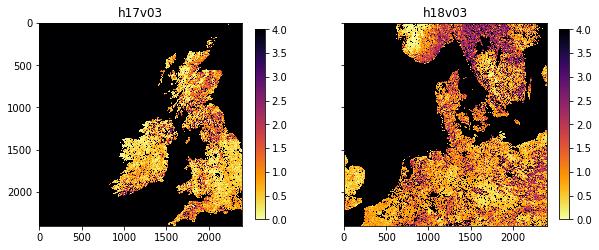

In [16]:
import gdal
from pathlib import Path
import matplotlib.pylab as plt
import numpy as np

filenames = sorted(Path('data').glob('*2018*v03*.hdf'))

out_directory = Path('images')

'''
Set up subplots of 1 row x 2 columns
'''
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,
                       figsize=(10,5))
# need to force axs collapse to a 2D array
# for indexing to be easy T here is transpose
# to get row/col the right way around
axs = np.array(axs).T.flatten()

for i,filename in enumerate(filenames):
    # pull the tile name from the filename
    # to use as plot title
    tile = filename.name.split('.')[2]
    
    
    dataset_name = f'HDF4_EOS:EOS_GRID:"{str(filename):s}\":MOD_Grid_MCD15A3H:Lai_500m'
    g = gdal.Open(dataset_name)
    data = g.ReadAsArray() * float(g.GetMetadata()['scale_factor'])

    img = axs[i].imshow(data, interpolation="nearest", vmin=0, vmax=4,
                 cmap=plt.cm.inferno_r)
    axs[i].set_title(tile)
    plt.colorbar(img,ax=axs[i],shrink=0.7)
    
# save figure as pdf this time
plot_name = 'joinedup.pdf'
print(plot_name)
out_filename = out_directory.joinpath(plot_name)
plt.savefig(out_filename)

**Exercise 3.3.5**

We now want to use the additional files:

    MCD15A3H.A2018273.h17v04.006.2018278143630.hdf	
    MCD15A3H.A2018273.h18v04.006.2018278143638.hdf

* copy and change the code above to use files of the pattern `*v0[3,4]*.hdf`
* use subplot as above to plot a 2x2 set of subplots of these data.


**Hint**

The code should look much like that above, but you need to give the fiuller list of filenames and set the subplot shape.

The code `[3,4]` in the pattern `*v0[3,4]*.hdf` means match either `3` or `4`, so the pattern must be `*v03*.hdf` or `*v03*.hdf`.

The result should look like:

![](images/joinedup4.pdf)

In [17]:
# do exercise here

### 3.3.3.3 tile stitching

You may want to generate a single view of the 4 tiles.

We could achieve this by stitching things together "by hand"...

**recipe:**

* First, lets generate a 3D dataset with all 4 tiles, so we have the images stored as members of a list `data[0]`,`data[1]`,`data[2]` and `data[3]`:

        data = []
        for filename in filenames:
            dataname = f'HDF4_EOS:EOS_GRID:"{str(filename):s}":MOD_Grid_MCD15A3H:Lai_500m'
            g = gdal.Open(dataname)
            data.append(g.ReadAsArray() * scale)

* then, we produce vertical stacks of the first two and last two files. This can be done in various ways, but it is perhaps clearest to use `np.vstack()`

        top = np.vstack([data[0],data[1]])
        bot = np.vstack([data[2],data[3]])
        
* then, produce a horizontal stack of these stacks:

        lai_stich = np.hstack([top,bot])
        
and plot the dataset

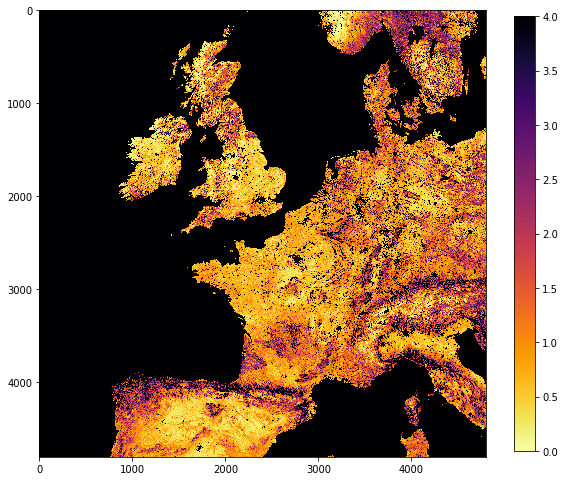

In [18]:
import gdal
from pathlib import Path
import matplotlib.pylab as plt

scale = 0.1

filenames = sorted(Path('data').glob('*2018*v0*.hdf'))

data = []
for filename in filenames:
    dataname = f'HDF4_EOS:EOS_GRID:"{str(filename)}":MOD_Grid_MCD15A3H:Lai_500m'
    g = gdal.Open(dataname)
    # append each image to the data list
    data.append(g.ReadAsArray() * scale)

top = np.vstack([data[0],data[1]])
bot = np.vstack([data[2],data[3]])

lai_stich = np.hstack([top,bot])

plt.figure(figsize=(10,10))
plt.imshow(lai_stich, interpolation="nearest", vmin=0, vmax=4,
          cmap=plt.cm.inferno_r)
plt.colorbar(shrink=0.8)

**Exercise 3.3.6**

* examine how the `vstack` and `hstack` methods work. Print out the shape of the array after stacking to appreciate this.
* how big (in pixels) is the whole dataset now? 
* If a `float` is 64 bits, how many bytes is this data array likely to be?

In [19]:
# do exercise here

### 3.3.3.4 `gdal` virtual file

However, stitching in this way is problematic if you want to mosaic many tiles, as you need to read in all the data in memory. Also,some tiles may be missing. GDAL allows you to create a mosaic as [virtual file format](https://www.gdal.org/gdal_vrttut.html), using gdal.BuildVRT (check the documentation). 

This function takes two inputs: the output filename (`stitch_up.vrt`) and a set of GDAL format filenames. It returns the open output dataset, so that we can check what it looks like with e.g. `gdal.Info`

In [20]:
import gdal
from pathlib import Path

# need to convert filenames to strings
# which we can do with p.as_posix() or str(p)
filenames = sorted([p.as_posix() for p in Path('data').glob('*273*v0[3,4]*.hdf')])
datanames = [f'HDF4_EOS:EOS_GRID:"{str(filename)}":MOD_Grid_MCD15A3H:Lai_500m' \
                for filename in filenames]
stitch_vrt = gdal.BuildVRT("stitch_up.vrt", datanames)

print(gdal.Info(stitch_vrt))

Driver: VRT/Virtual Raster
Files: stitch_up.vrt
Size is 4800, 4800
Coordinate System is:
PROJCS["unnamed",
    GEOGCS["Unknown datum based upon the custom spheroid",
        DATUM["Not specified (based on custom spheroid)",
            SPHEROID["Custom spheroid",6371007.181,0]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433]],
    PROJECTION["Sinusoidal"],
    PARAMETER["longitude_of_center",0],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["Meter",1]]
Origin = (-1111950.519667000044137,6671703.117999999783933)
Pixel Size = (463.312716527916677,-463.312716527708290)
Corner Coordinates:
Upper Left  (-1111950.520, 6671703.118) ( 20d 0' 0.00"W, 60d 0' 0.00"N)
Lower Left  (-1111950.520, 4447802.079) ( 13d 3'14.66"W, 40d 0' 0.00"N)
Upper Right ( 1111950.520, 6671703.118) ( 20d 0' 0.00"E, 60d 0' 0.00"N)
Lower Right ( 1111950.520, 4447802.079) ( 13d 3'14.66"E, 40d 0' 0.00"N)
Center      (       0.000, 5559752.598) (  0d 0' 0.01"E, 50d 

So we see that we now have 4800 columns by 4800 rows dataset, centered around 0 degrees North, 0 degrees W. Let's plot the data...

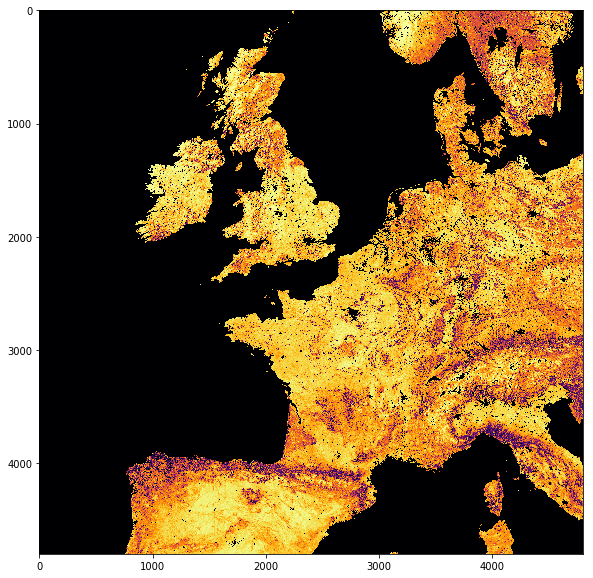

In [21]:
# stitch_vrt is an already opened GDAL dataset, needs to be read in
plt.figure(figsize=(10,10))
plt.imshow(stitch_vrt.ReadAsArray()*0.1,
           interpolation="nearest", vmin=0, vmax=6, 
          cmap=plt.cm.inferno_r)

## 3.3.4 The country borders dataset

A number of vectors with countries and administrative subdivisions are available. The [TM_WORLD_BORDERS shapefile](http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip) is popular and in the public domain. You can see it, and have a look at the data [here](https://koordinates.com/layer/7354-tm-world-borders-03/). We need to download and unzip this file... We'll use requests as before, and we'll unpack the zip file using [`shutil.unpack_archive`](https://docs.python.org/3/library/shutil.html#shutil.unpack_archive)

In [1]:
import requests
import shutil 

tm_borders_url = "http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip"

r = requests.get(tm_borders_url)
with open("data/TM_WORLD_BORDERS-0.3.zip", 'wb') as fp:
    fp.write (r.content)

shutil.unpack_archive("data/TM_WORLD_BORDERS-0.3.zip",
                     extract_dir="data/")

Make sure you have the relevant files available in your `data` folder! We can then inspect the dataset using the command line tool `ogrinfo`. We can call it from the shell by appending the `!` symbol, and select that we want to check only the data for the UK (stored in the `FIPS` field with value `UK`):


It is worth noting that using OGR's queries trying to match a string, the string needs to be surrounded by `'`. You can also use more complicated SQL queries if you wanted to.

In [2]:
!ogrinfo -nomd -geom=NO -where "FIPS='UK'"  data/TM_WORLD_BORDERS-0.3.shp TM_WORLD_BORDERS-0.3 

INFO: Open of `data/TM_WORLD_BORDERS-0.3.shp'
      using driver `ESRI Shapefile' successful.

Layer name: TM_WORLD_BORDERS-0.3
Geometry: Polygon
Feature Count: 1
Extent: (-180.000000, -90.000000) - (180.000000, 83.623596)
Layer SRS WKT:
GEOGCS["GCS_WGS_1984",
    DATUM["WGS_1984",
        SPHEROID["WGS_84",6378137.0,298.257223563]],
    PRIMEM["Greenwich",0.0],
    UNIT["Degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
FIPS: String (2.0)
ISO2: String (2.0)
ISO3: String (3.0)
UN: Integer (3.0)
NAME: String (50.0)
AREA: Integer (7.0)
POP2005: Integer64 (10.0)
REGION: Integer (3.0)
SUBREGION: Integer (3.0)
LON: Real (8.3)
LAT: Real (7.3)
OGRFeature(TM_WORLD_BORDERS-0.3):206
  FIPS (String) = UK
  ISO2 (String) = GB
  ISO3 (String) = GBR
  UN (Integer) = 826
  NAME (String) = United Kingdom
  AREA (Integer) = 24193
  POP2005 (Integer64) = 60244834
  REGION (Integer) = 150
  SUBREGION (Integer) = 154
  LON (Real) = -1.600
  LAT (Real) = 53.000



We inmediately see that the coordinates for the UK are in several polygons, and in WGS84 (Latitude and Longitude in decimal degrees). This is incompatible with the MODIS data (SIN projection), but fortunately GDAL understands about coordinate systems.

We can use GDAL to quickly apply the vector feature for the UK as a mask. There are several ways of doing this, but the simplest is to use [gdal.Warp](https://www.gdal.org/gdalwarp.html) (the link is to the command line tool). In this case, we just want to create:

* an in-memory (i.e. not saved to a file) dataset. We can use the format `MEM`, so no file is written out.
* where the `FIPS` field is equal to `'UK'`, we want the LAI to show, elsewhere, we set it to some value to indicate "no data" (e.g. -999)

The mosaicked version of the MODIS LAI product is in called `stitch_up.vrt`. Since we're not saving the output to a file (`MEM` output option), we can leave the output as an empty string `""`. The shapefile comes with the `cutline` options:

* `cutlineDSName` that's the name of the vector file we want to use as a cutline
* `cutlineWhere` that's the selection statement for the attribute table in the dataset. 

To set the no data value to 200, we can use the option `dstNodata=200`. This is because very large values in the LAI product are already indicated to be invalid.

We can then just very quickly perform this and check...

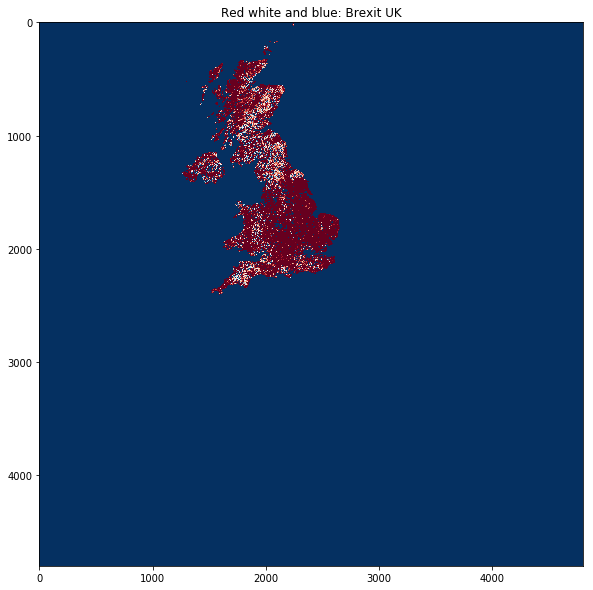

In [24]:
import gdal
import matplotlib.pylab as plt
from pathlib import Path

filenames = sorted([p.as_posix() for p in Path('data').glob('*2018*v0*.hdf')])
datanames = [f'HDF4_EOS:EOS_GRID:"{str(filename)}":MOD_Grid_MCD15A3H:Lai_500m' \
                for filename in filenames]
stitch_vrt = gdal.BuildVRT("stitch_up.vrt", datanames)


g = gdal.Warp("", "stitch_up.vrt",
         format = 'MEM',dstNodata=200,
          cutlineDSName = 'data/TM_WORLD_BORDERS-0.3.shp', cutlineWhere = "FIPS='UK'")

# read and plot data
masked_lai = g.ReadAsArray()*0.1
plt.figure(figsize=(10,10))
plt.title('Red white and blue: Brexit UK')
plt.imshow(masked_lai, interpolation="nearest", vmin=1, vmax=3, 
          cmap=plt.cm.RdBu)

So that works as expected, but since we haven't actually told GDAL anything about the output (other than apply the mask), we still have a 4800 pixel wide dataset. 

You may want to crop it by looking for where the original dataset is  valid (0 to 100 here). This will generally save a lot of computer memory. You'll be pleased to know that this is a great slicing application!

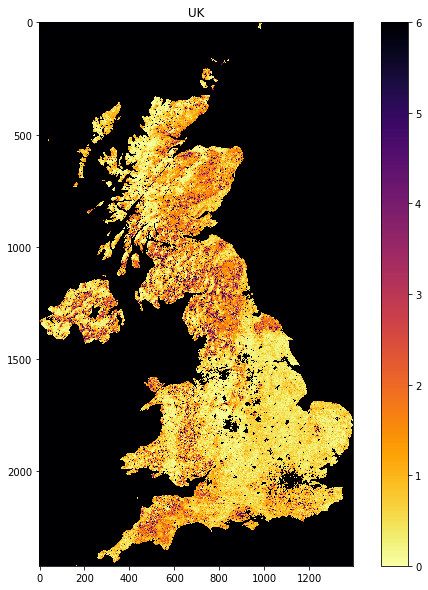

In [25]:
import numpy as np

lai = g.ReadAsArray()

# data valid where lai <= 100 here
valid_mask = np.where(lai <= 100)

# work out the bounds of valid_mask
min_y      = valid_mask[0].min()
max_y      = valid_mask[0].max() + 1

min_x      = valid_mask[1].min()
max_x      = valid_mask[1].max() + 1

# now slice, and scale LAI
lai = lai[min_y:max_y,
          min_x:max_x]*0.1

plt.figure(figsize=(10,10))
plt.imshow(lai, vmin=0, vmax=6,
           cmap=plt.cm.inferno_r)
plt.title('UK')
plt.colorbar()


**Exercise 3.3.7** **Homework**

* Develop a function that takes the list of dataset names and the information you passed to `gdal.Warp` (or a subset of this) and returns a cropped image of valid data.
* Use this function to show separate images of: France, Belgium, the Netherlands

In [26]:
# do exercise here

**Exercise 3.3.8** **Homework**

* Download data for these same four tiles from the **MODIS snow cover** dataset for some particular date (in winter). Check the related quicklooks to see that the dataset isn't all covered in cloud.
* show the snow cover for one or more selected countries.
* calculate summary statistics for the datasets.

**Hint** the codes would be very similar to above, but watch out for the scaling factor not being the same (no scaling for the snow cover!). Also, watch out for the dataset being on a different NASA server to the LAI data (as in exercise above).

When you calculate summary statistics, make sure you ignore all invalid pixels. You could do that by generating a mask of the dataset (after you have clipped it) using `np.where()`, and only process those pixels, e.g.:

    image[np.where(image<=100)].mean()
    
rather than

    image.mean()
    
as the latter would include invalid pixels.

In [27]:
# do exercise here